# Plotting with Pandas
The `plot()` method is available on `Series` and `DataFrame` objects. Many of the parameters get passed down to matplotlib. The `kind` argument let's us vary the plot type.

## About the Data
In this notebook, we will be working with 2 datasets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis))
- Earthquake data from September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/))

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fb = pd.read_csv(
    'data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True
)
quakes = pd.read_csv('data/earthquakes.csv')

## Evolution over time
Line plots help us see how a variable changes over time. They are the default for the `kind` argument, but we can pass `kind='line'` to be explicit in our intent:

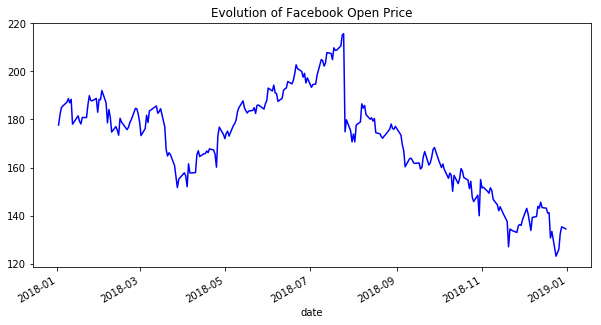

In [2]:
fb.plot(
    kind='line',
    y='open',
    figsize=(10, 5),
    style='b-',
    legend=False,
    title='Evolution of Facebook Open Price'
)

We provided the `style` argument in the previous example; however, we can use the `color` and `linestyle` arguments to get the same result:

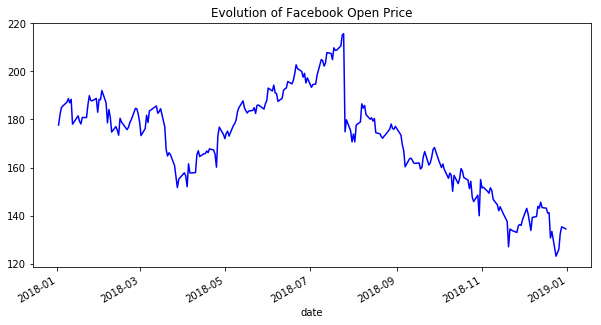

In [3]:
fb.plot(
    kind='line',
    y='open',
    figsize=(10, 5),
    color='blue',
    linestyle='solid',
    legend=False,
    title='Evolution of Facebook Open Price'
)

We can also plot many lines at once by simply passing a list of the columns to plot:

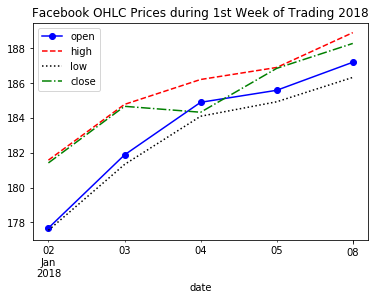

In [4]:
fb.iloc[:5,].plot(
    y=['open', 'high', 'low', 'close'],
    style=['b-o', 'r--', 'k:', 'g-.'],
    title='Facebook OHLC Prices during 1st Week of Trading 2018'
)

## Creating subplots
When plotting with pandas, creating subplots is simply a matter of passing `subplots=True` to the `plot()` method, and (optionally) specifying the `layout` in a tuple of `(rows, columns)`:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121D0B50>,
      dtype=object)

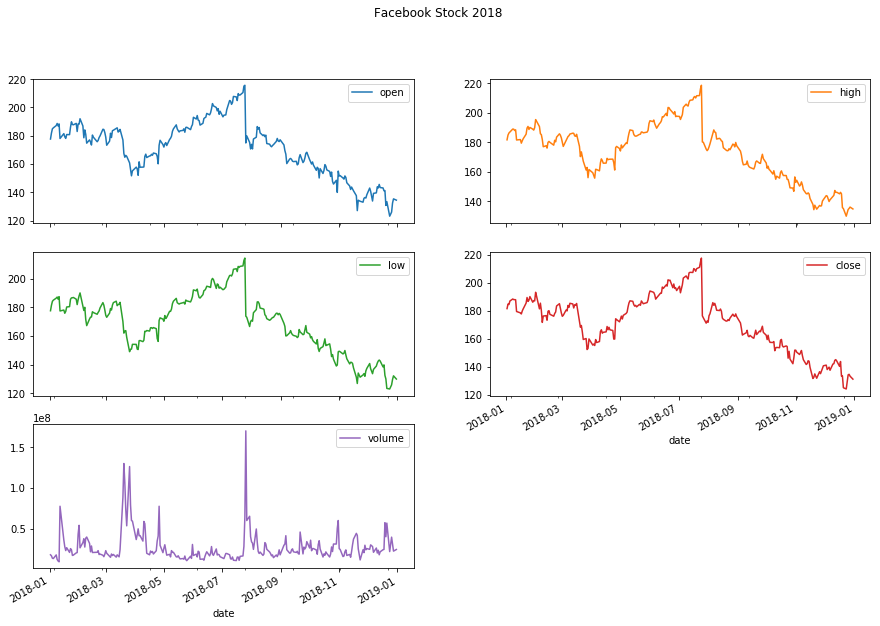

In [5]:
fb.plot(
    kind='line',
    subplots=True,
    layout=(3,2),
    figsize=(15,10),
    title='Facebook Stock 2018'
)

Note that we didn't provide a specific column to plot and pandas plotted all of them for us.

## Visualizing relationships between variables
### Scatter plots
We make scatter plots to help visualize the relationship between two variables. Creating scatter plots requires we pass in `kind='scatter'` along with a column for the x-axis and a column for the y-axis:

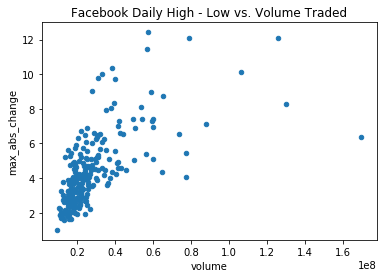

In [6]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. Volume Traded'
)

The relationship doesn't seem to be linear, but we can try a log transform on the x-axis since the scales of the axes are very different. With pandas, we simply pass in `logx=True`:

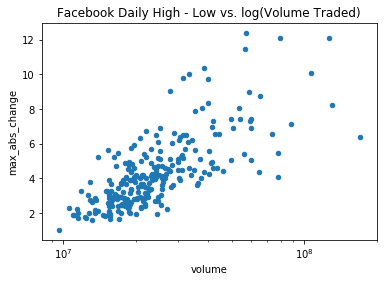

In [7]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)', 
    logx=True
)

With matplotlib, we could use `plt.xscale('log')` to do the same thing.

### Adding Transparency to Plots with `alpha`
Sometimes our plots have many overlapping values, but this can be impossible to see. This can be addressed by increasing the transparency of what we are plotting using the `alpha` parameter. It is a float on [0, 1] where 0 is completely transparent and 1 is completely opaque. By default this is 1, so let's put in a lower value and re-plot the scatter plot:

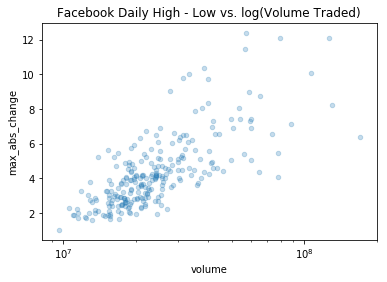

In [8]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)',
    logx=True, alpha=0.25
)

### Hexbins
In the previous example, we can start to see the overlaps, but it is still difficult. Hexbins are another plot type that divide up the plot into hexagons, which are shaded according to the density of points there. With pandas, this is the `hexbin` value for the `kind` argument. It can also be important to tweak the `gridsize`, which determines the number of hexagons along the y-axis:

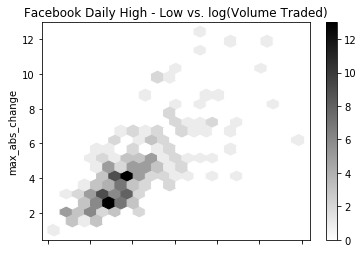

In [9]:
fb.assign(
    volume=np.log(fb.volume),
    max_abs_change=fb.high - fb.low
).plot(
    kind='hexbin',
    x='volume',
    y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)',
    colormap='gray_r',
    gridsize=20
)

### Visualizing Correlations with Heatmaps
Pandas doesn't offer heatmaps; however, if we are able to get our data into a matrix, we can use `matshow()` from matplotlib:

[Text(0, 0, ''),
 Text(0, 0, 'open'),
 Text(0, 0, 'high'),
 Text(0, 0, 'low'),
 Text(0, 0, 'close'),
 Text(0, 0, 'volume'),
 Text(0, 0, 'log_volume'),
 Text(0, 0, 'max_abs_change')]

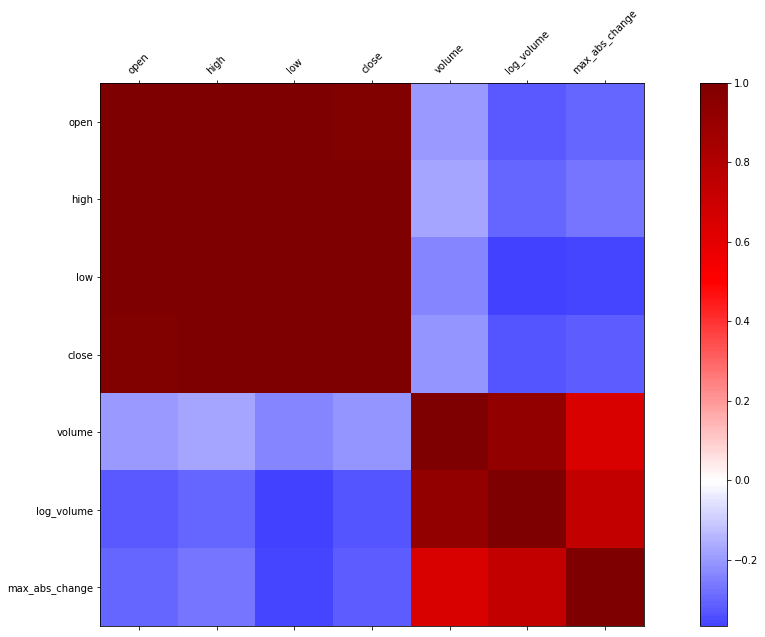

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

fb_corr = fb.assign(
    log_volume=np.log(fb.volume),
    max_abs_change=fb.high - fb.low
).corr()

im = ax.matshow(fb_corr, cmap='seismic')
fig.colorbar(im).set_clim(-1, 1)

labels = [col.lower() for col in fb_corr.columns]
ax.set_xticklabels([''] + labels, rotation=45)
ax.set_yticklabels([''] + labels)

In [11]:
fb_corr.loc['max_abs_change', ['volume', 'log_volume']]

volume        0.642027
log_volume    0.731542
Name: max_abs_change, dtype: float64

## Visualizing distributions
### Histograms
With the pandas `plot()` method, making histograms is as easy as passing in `kind='hist'`:

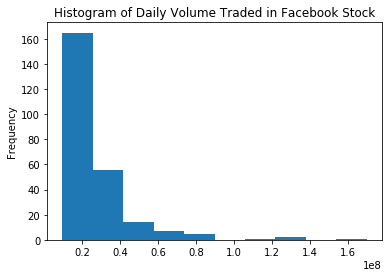

In [12]:
fb.volume.plot(
    kind='hist', 
    title='Histogram of Daily Volume Traded in Facebook Stock'
)

We can overlap histograms to compare distributions provided we use the `alpha` parameter. For example, let's compare the usage and magnitude of the various `magTypes` in the data:

Text(0.5, 0, 'magnitude')

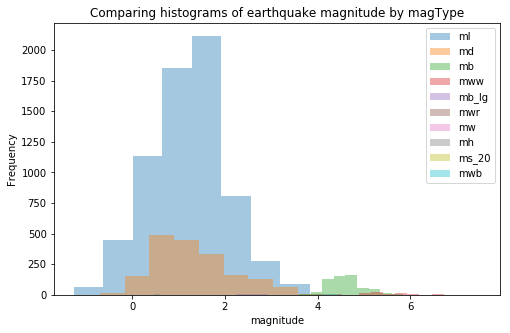

In [13]:
fig, axes = plt.subplots(figsize=(8, 5))
for magtype in quakes.magType.unique():
    data = quakes.query(f'magType == "{magtype}"').mag
    if not data.empty:
        data.plot(
            kind='hist', ax=axes, alpha=0.4, 
            label=magtype, legend=True,
            title='Comparing histograms of earthquake magnitude by magType'
        )
plt.xlabel('magnitude') # label the x-axis (discussed in chapter 6)

### Kernel Density Estimation (KDE)
We can pass `kind='kde'` for a probability density function (PDF), which tells us the probability of getting a particular value:

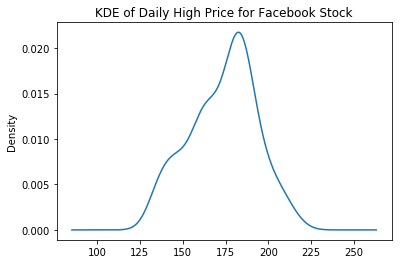

In [14]:
fb.high.plot(
    kind='kde', 
    title='KDE of Daily High Price for Facebook Stock'
)

### Adding to the result of `plot()`
The `plot()` method returns a matplotlib `Axes` object. We can store this for additional customization of the plot, or we can pass this into another call to `plot()` as the `ax` argument to add to the original plot. 

It can often be helpful to view the KDE superimposed on top of the histogram, which can be achieved with this strategy:

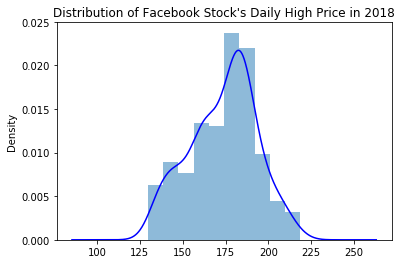

In [15]:
ax = fb.high.plot(kind='hist', density=True, alpha=0.5)
fb.high.plot(
    ax=ax, kind='kde', color='blue', 
    title='Distribution of Facebook Stock\'s Daily High Price in 2018'
)

### Plotting the ECDF
In some cases, we are more interested in the probability of getting less than or equal to that value (or greater than or equal), which we can see with the cumulative disribution function (CDF). Using the `statsmodels` package, we can estimate the CDF giving us the empirical cumulative distribution function (ECDF):

Text(0.5, 1.0, 'ECDF of earthquake magnitude with magType ml')

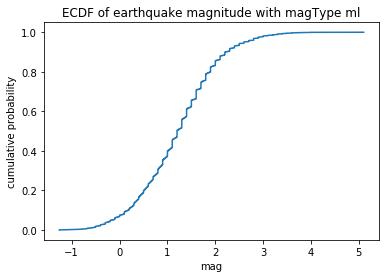

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(quakes.query('magType == "ml"').mag)
plt.plot(ecdf.x, ecdf.y)

# axis labels (we will cover this in chapter 6)
plt.xlabel('mag') # add x-axis label 
plt.ylabel('cumulative probability') # add y-axis label

# add title (we will cover this in chapter 6)
plt.title('ECDF of earthquake magnitude with magType ml')

This ECDF tells us the probability of getting an earthquake with magnitude of 3 or less using the `ml` scale is 98%:

Text(0.5, 1.0, 'P(mag <= 3) = 98%')

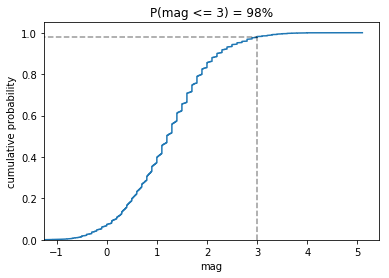

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(quakes.query('magType == "ml"').mag)
plt.plot(ecdf.x, ecdf.y)

# formatting below will all be covered in chapter 6
# axis labels
plt.xlabel('mag') # add x-axis label 
plt.ylabel('cumulative probability') # add y-axis label

# add reference lines for interpreting the ECDF for mag <= 3 
plt.plot(
    [3, 3], [0, .98], 'k--', 
    [-1.5, 3], [0.98, 0.98], 'k--', alpha=0.4
)

# set axis ranges
plt.ylim(0, None)
plt.xlim(-1.25, None)

# add a title
plt.title('P(mag <= 3) = 98%')

### Box plots
To make box plots with pandas, we pass `kind='box'` to the `plot()` method:

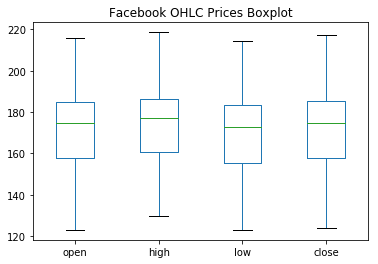

In [18]:
fb.iloc[:,:4].plot(kind='box', title='Facebook OHLC Prices Boxplot')

This can also be combined with a `groupby()`:

Text(0.5, 1.1, 'Facebook OHLC Boxplots by Volume Traded')

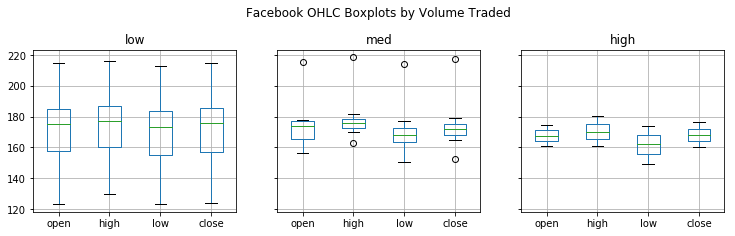

In [19]:
fb.assign(
    volume_bin=pd.cut(fb.volume, 3, labels=['low', 'med', 'high'])
).groupby('volume_bin').boxplot(
    column=['open', 'high', 'low', 'close'],
    layout=(1, 3), figsize=(12, 3)
)
plt.suptitle('Facebook OHLC Boxplots by Volume Traded', y=1.1)

We can use this to see the distribution of magnitudes across the different measurement methods for earthquakes:

Text(0, 0.5, 'magnitude')

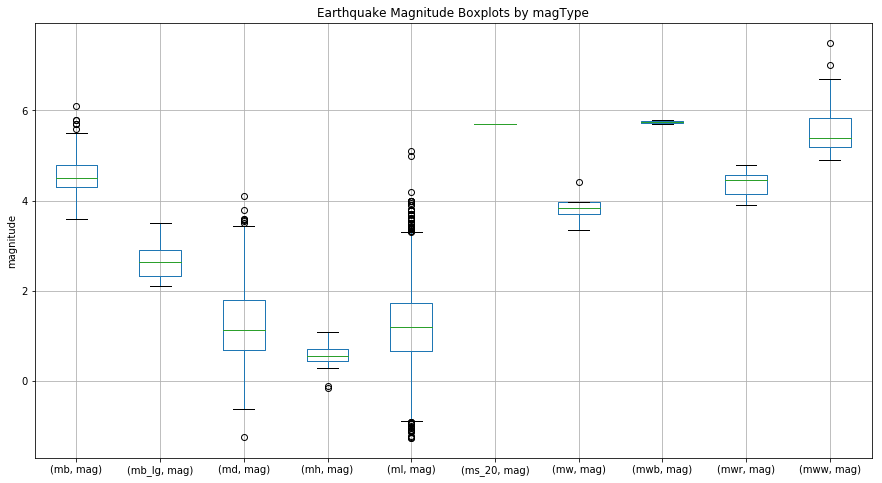

In [20]:
quakes[['mag', 'magType']].groupby('magType').boxplot(
    figsize=(15, 8), subplots=False
)
plt.title('Earthquake Magnitude Boxplots by magType')
plt.ylabel('magnitude')

## Counts and frequencies
### Bar charts
With pandas, we have the option of using the `kind` argument or using `plot.<kind>()`. Let's use `plot.bar()` here to show the evolution of monthly volume traded in Facebook stock over time:

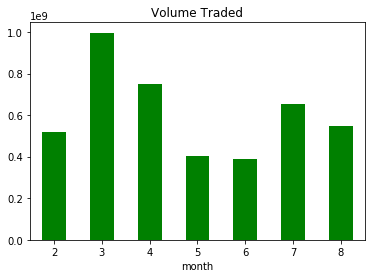

In [21]:
fb['2018-02':'2018-08'].assign(
    month=lambda x: x.index.month
).groupby('month').sum().volume.plot.bar(
    color='green', rot=0, title='Volume Traded'
)

We can also change the orientation of the bars. Passing `kind='barh'` gives us horizontal bars instead of vertical ones. Let's use this to look at the top 15 places for earthquakes in our data:

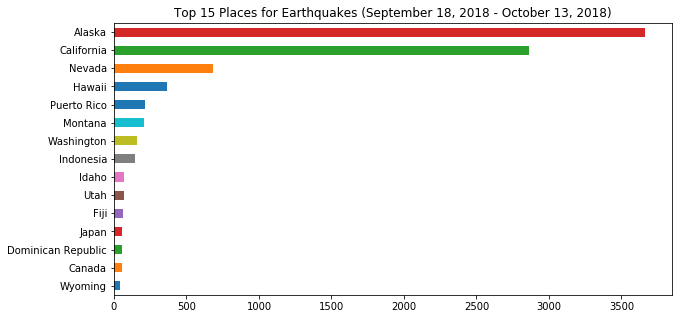

In [22]:
quakes.parsed_place.value_counts().iloc[14::-1,].plot(
    kind='barh', figsize=(10, 5),
    title='Top 15 Places for Earthquakes '\
        '(September 18, 2018 - October 13, 2018)'
)

We also have data on whether earthquakes were accompanied by tsunamis. Let's see what the top places for tsunamis are:

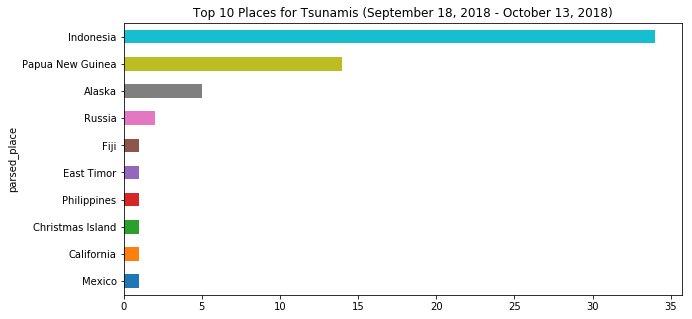

In [23]:
quakes.groupby('parsed_place').tsunami.sum().sort_values().iloc[-10::,].plot(
    kind='barh', figsize=(10, 5), 
    title='Top 10 Places for Tsunamis '\
        '(September 18, 2018 - October 13, 2018)'
)

Seeing that Indonesia is the top place for tsunamis during the time period we are looking at, we may want to look how many earthquakes and tsunamis Indonesia gets on a daily basis. We could show this as a line plot or with bars; since this section is about bars, we will use bars here:

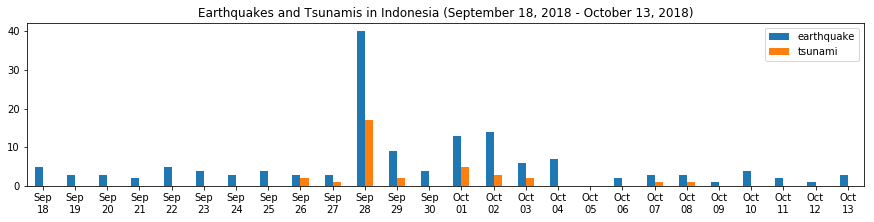

In [24]:
indonesia_quakes = quakes.query('parsed_place == "Indonesia"').assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms'),
    earthquake=1
).set_index('time').resample('1D').sum()

indonesia_quakes.index = indonesia_quakes.index.strftime('%b\n%d')

indonesia_quakes.plot(
    y=['earthquake', 'tsunami'], kind='bar', figsize=(15, 3), rot=0,
    title='Earthquakes and Tsunamis in Indonesia '\
        '(September 18, 2018 - October 13, 2018)'
)

Using the `kind` arugment for vertical bars when the labels for each bar are shorter:

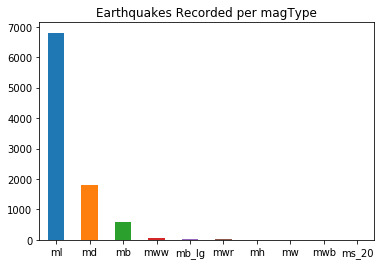

In [25]:
quakes.magType.value_counts().plot(
    kind='bar', title='Earthquakes Recorded per magType', rot=0
)

Top 4 places with earthquakes:

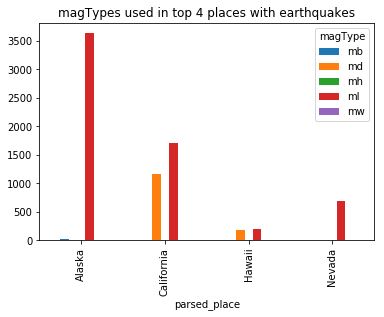

In [26]:
quakes[
    quakes.parsed_place.isin(['California', 'Alaska', 'Nevada', 'Hawaii'])
].groupby(['parsed_place', 'magType']).mag.count().unstack().plot.bar(
    title='magTypes used in top 4 places with earthquakes'
)

### Stacked bar chart

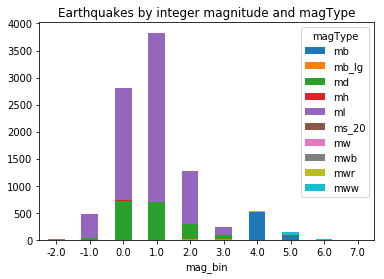

In [27]:
pivot = quakes.assign(
    mag_bin=lambda x: np.floor(x.mag)
).pivot_table(
    index='mag_bin', columns='magType', values='mag', aggfunc='count'
)
pivot.plot.bar(
    stacked=True, rot=0, 
    title='Earthquakes by integer magnitude and magType'
)

#### Normalized stacked bars
Plot the percentages to be better able to see the different `magTypes`.

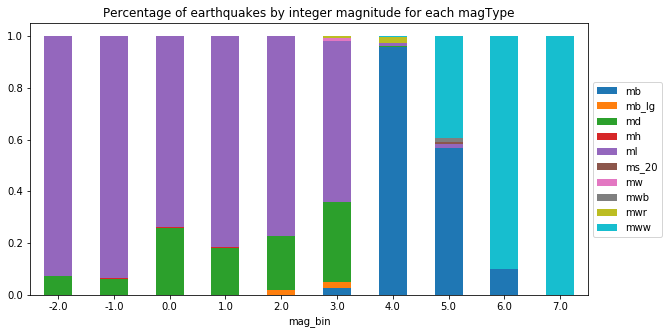

In [28]:
normalized_pivot = pivot.fillna(0).apply(lambda x: x/x.sum(), axis=1)
ax = normalized_pivot.plot.bar(
    stacked=True, rot=0, figsize=(10, 5),
    title='Percentage of earthquakes by integer magnitude for each magType'
)
ax.legend(bbox_to_anchor=(1, 0.8)) # move legend to the right of the plot